# PyTorch Refresher for TRM Codebase

This notebook covers the essential PyTorch concepts used in this codebase.
Each section explains a technique with examples relevant to TRM.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Optional, Dict
import math

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1+cu128


## 1. Tensor Basics and dtypes

The codebase uses `bfloat16` for efficient training while maintaining numerical stability.

In [3]:
# Creating tensors with specific dtypes
x_float32 = torch.randn(2, 3, dtype=torch.float32)
x_bfloat16 = torch.randn(2, 3, dtype=torch.bfloat16)

print(f"float32 tensor: {x_float32.dtype}")
print(f"bfloat16 tensor: {x_bfloat16.dtype}")

# Converting between dtypes (used throughout the codebase for mixed precision)
x_converted = x_float32.to(torch.bfloat16)
print(f"\nConverted: {x_converted.dtype}")

# bfloat16 has same exponent range as float32 but less precision
# This is why it's preferred over float16 for training

float32 tensor: torch.float32
bfloat16 tensor: torch.bfloat16

Converted: torch.bfloat16


In [4]:
# Common tensor operations used in the codebase
batch, seq_len, hidden = 2, 10, 64
x = torch.randn(batch, seq_len, hidden)

# Reshaping (used for multi-head attention)
num_heads = 8
head_dim = hidden // num_heads
x_reshaped = x.view(batch, seq_len, num_heads, head_dim)
print(f"Reshaped for multi-head: {x_reshaped.shape}")

# Transpose (swapping dimensions for attention)
# Pattern: (batch, seq, heads, head_dim) -> (batch, heads, seq, head_dim)
x_transposed = x_reshaped.transpose(1, 2)
print(f"Transposed: {x_transposed.shape}")

# Contiguous - ensures memory is laid out sequentially
x_contiguous = x_transposed.contiguous()
print(f"Is contiguous: {x_contiguous.is_contiguous()}")

Reshaped for multi-head: torch.Size([2, 10, 8, 8])
Transposed: torch.Size([2, 8, 10, 8])
Is contiguous: True


## 2. nn.Module - Building Models

The TRM uses hierarchical nn.Module composition. All models inherit from `nn.Module`.

In [5]:
class SimpleBlock(nn.Module):
    """A simple transformer-like block similar to TRM's blocks."""
    
    def __init__(self, hidden_size: int, expansion: int = 4):
        super().__init__()  # Always call parent's __init__
        
        # Layers are registered automatically as attributes
        self.norm = nn.LayerNorm(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size * expansion)
        self.fc2 = nn.Linear(hidden_size * expansion, hidden_size)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Residual connection pattern (used everywhere in TRM)
        residual = x
        x = self.norm(x)
        x = F.silu(self.fc1(x))  # SiLU/Swish activation
        x = self.fc2(x)
        return x + residual  # Add residual

# Test it
block = SimpleBlock(hidden_size=64)
x = torch.randn(2, 10, 64)
out = block(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])


In [6]:
# Inspecting model parameters (important for debugging)
print("Named parameters:")
for name, param in block.named_parameters():
    print(f"  {name}: {param.shape}")

# Count total parameters
total_params = sum(p.numel() for p in block.parameters())
print(f"\nTotal parameters: {total_params:,}")

Named parameters:
  norm.weight: torch.Size([64])
  norm.bias: torch.Size([64])
  fc1.weight: torch.Size([256, 64])
  fc1.bias: torch.Size([256])
  fc2.weight: torch.Size([64, 256])
  fc2.bias: torch.Size([64])

Total parameters: 33,216


## 3. nn.Buffer - Non-Parameter Tensors

TRM uses `nn.Buffer` for persistent state that isn't a learnable parameter (e.g., cached embeddings, initialization tensors).

In [7]:
class ModuleWithBuffer(nn.Module):
    """Demonstrates nn.Buffer usage like in TRM."""
    
    def __init__(self, hidden_size: int):
        super().__init__()
        
        # nn.Buffer: saved with model state, moves with .to(device), 
        # but not updated by optimizer
        # Used for initial hidden states in TRM
        self.H_init = nn.Buffer(
            torch.randn(1, 1, hidden_size) * 0.02,
            persistent=True  # Saved in state_dict
        )
        
        # Non-persistent buffer: not saved but still moves with model
        self.cache = nn.Buffer(
            torch.zeros(1),
            persistent=False
        )
        
        self.linear = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Expand init state to batch size
        batch_size = x.shape[0]
        h = self.H_init.expand(batch_size, -1, -1)
        return self.linear(x + h)

model = ModuleWithBuffer(64)
print("State dict keys (only persistent buffers and params):")
for key in model.state_dict().keys():
    print(f"  {key}")

State dict keys (only persistent buffers and params):
  H_init
  linear.weight
  linear.bias


## 4. Embeddings

TRM uses embeddings for tokens and puzzle identifiers. Understanding `nn.Embedding` is essential.

In [8]:
# Basic embedding: maps integer indices to dense vectors
vocab_size = 100
embed_dim = 64

embedding = nn.Embedding(vocab_size, embed_dim)

# Input: integer token IDs
token_ids = torch.tensor([[1, 5, 10, 3], [2, 8, 4, 1]])
print(f"Input token IDs shape: {token_ids.shape}")

# Output: dense vectors for each token
embeddings = embedding(token_ids)
print(f"Embeddings shape: {embeddings.shape}")

Input token IDs shape: torch.Size([2, 4])
Embeddings shape: torch.Size([2, 4, 64])


In [9]:
# Custom embedding with dtype casting (like CastedEmbedding in TRM)
class CastedEmbedding(nn.Embedding):
    """Embedding that casts output to a specific dtype."""
    
    def __init__(self, num_embeddings, embedding_dim, dtype=torch.bfloat16, **kwargs):
        super().__init__(num_embeddings, embedding_dim, **kwargs)
        self.output_dtype = dtype
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get embeddings in float32, then cast
        return super().forward(x).to(self.output_dtype)

emb = CastedEmbedding(100, 64, dtype=torch.bfloat16)
out = emb(torch.tensor([1, 2, 3]))
print(f"Output dtype: {out.dtype}")

Output dtype: torch.bfloat16


## 5. Attention Mechanism

TRM uses multi-head self-attention with Rotary Position Embeddings (RoPE).

In [10]:
class SimpleAttention(nn.Module):
    """Simplified attention similar to TRM's implementation."""
    
    def __init__(self, hidden_size: int, num_heads: int):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        # Q, K, V projections (TRM uses separate linear layers)
        self.q_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.k_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.v_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.out_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch, seq_len, hidden = x.shape
        
        # Project to Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        # Reshape for multi-head: (batch, seq, heads, head_dim)
        q = q.view(batch, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Now: (batch, heads, seq, head_dim)
        
        # Scaled dot-product attention (PyTorch's optimized version)
        # TRM uses is_causal=False because it's not autoregressive
        attn_out = F.scaled_dot_product_attention(
            q, k, v,
            is_causal=False  # Non-causal (bidirectional) attention
        )
        
        # Reshape back: (batch, seq, hidden)
        attn_out = attn_out.transpose(1, 2).contiguous().view(batch, seq_len, -1)
        
        return self.out_proj(attn_out)

# Test
attn = SimpleAttention(hidden_size=64, num_heads=8)
x = torch.randn(2, 10, 64)
out = attn(x)
print(f"Attention output shape: {out.shape}")

Attention output shape: torch.Size([2, 10, 64])


In [11]:
# Rotary Position Embeddings (RoPE) - simplified version
# TRM uses this for position encoding

def compute_rope_freqs(dim: int, seq_len: int, base: float = 10000.0):
    """Compute RoPE frequency tensor."""
    # Inverse frequencies for each dimension pair
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
    
    # Position indices
    positions = torch.arange(seq_len).float()
    
    # Outer product: (seq_len, dim/2)
    freqs = torch.outer(positions, inv_freq)
    
    # Cos and sin for rotation
    cos = freqs.cos()
    sin = freqs.sin()
    
    return cos, sin

def rotate_half(x):
    """Rotate half of the dimensions."""
    x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
    return torch.cat((-x2, x1), dim=-1)

def apply_rope(x, cos, sin):
    """Apply rotary embeddings to input."""
    return (x * cos) + (rotate_half(x) * sin)

# Example
head_dim = 32
seq_len = 10
cos, sin = compute_rope_freqs(head_dim, seq_len)
print(f"RoPE cos shape: {cos.shape}")
print(f"RoPE sin shape: {sin.shape}")

RoPE cos shape: torch.Size([10, 16])
RoPE sin shape: torch.Size([10, 16])


## 6. SwiGLU Activation

TRM uses SwiGLU (Swish-Gated Linear Unit) for the FFN layers.

SwiGLU output shape: torch.Size([2, 10, 64])


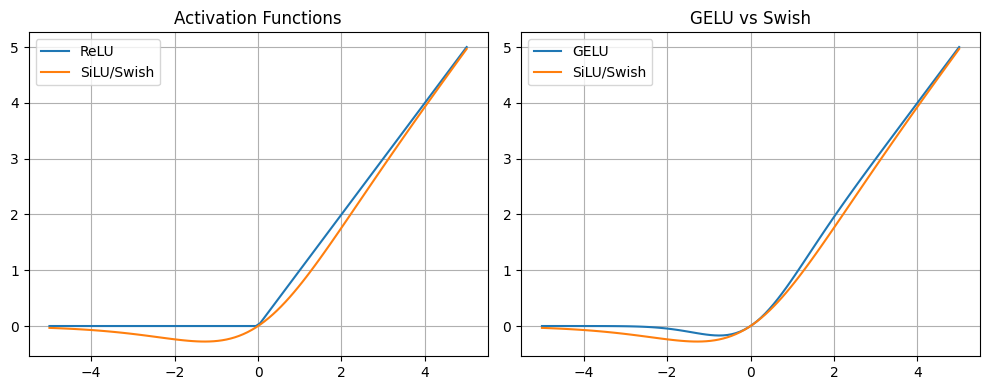

In [12]:
class SwiGLU(nn.Module):
    """SwiGLU activation as used in TRM.
    
    SwiGLU(x) = (xW1) * swish(xV)
    Where swish(x) = x * sigmoid(x)
    """
    
    def __init__(self, hidden_size: int, expansion: int = 4):
        super().__init__()
        intermediate = int(hidden_size * expansion * 2 / 3)  # Common scaling
        
        # Two parallel projections for gating
        self.w1 = nn.Linear(hidden_size, intermediate, bias=False)
        self.v = nn.Linear(hidden_size, intermediate, bias=False)
        self.w2 = nn.Linear(intermediate, hidden_size, bias=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Gated activation
        gate = F.silu(self.v(x))  # silu = swish
        x = self.w1(x) * gate
        return self.w2(x)

# Compare activations
x = torch.randn(2, 10, 64)
swiglu = SwiGLU(64)
out = swiglu(x)
print(f"SwiGLU output shape: {out.shape}")

# Visualize the swish/silu function
import matplotlib.pyplot as plt
x_vals = torch.linspace(-5, 5, 100)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_vals, F.relu(x_vals), label='ReLU')
plt.plot(x_vals, F.silu(x_vals), label='SiLU/Swish')
plt.legend()
plt.title('Activation Functions')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(x_vals, F.gelu(x_vals), label='GELU')
plt.plot(x_vals, F.silu(x_vals), label='SiLU/Swish')
plt.legend()
plt.title('GELU vs Swish')
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. RMS Normalization

TRM uses RMSNorm instead of LayerNorm (simpler and faster).

In [13]:
def rms_norm(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """Root Mean Square Layer Normalization.
    
    Unlike LayerNorm, RMSNorm doesn't subtract mean.
    """
    # Compute in float32 for stability (like in TRM)
    input_dtype = x.dtype
    x = x.to(torch.float32)
    
    # RMS: sqrt(mean(x^2))
    variance = x.pow(2).mean(-1, keepdim=True)
    x = x * torch.rsqrt(variance + eps)
    
    return x.to(input_dtype)

class RMSNorm(nn.Module):
    """RMSNorm with learnable scale."""
    
    def __init__(self, hidden_size: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(hidden_size))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return rms_norm(x, self.eps) * self.weight

# Compare LayerNorm vs RMSNorm
x = torch.randn(2, 10, 64)
ln = nn.LayerNorm(64)
rn = RMSNorm(64)

print(f"LayerNorm output mean: {ln(x).mean():.6f}")
print(f"RMSNorm output mean: {rn(x).mean():.6f}")
print(f"LayerNorm output std: {ln(x).std():.6f}")
print(f"RMSNorm output std: {rn(x).std():.6f}")

LayerNorm output mean: 0.000000
RMSNorm output mean: 0.034362
LayerNorm output std: 1.000386
RMSNorm output std: 0.999800


## 8. Loss Functions

TRM uses custom loss functions including cross-entropy for language modeling and BCE for Q-learning.

In [14]:
# Standard cross-entropy for classification
batch_size, num_classes = 4, 10
logits = torch.randn(batch_size, num_classes)
targets = torch.randint(0, num_classes, (batch_size,))

# Using F.cross_entropy (combines log_softmax + nll_loss)
loss = F.cross_entropy(logits, targets)
print(f"Cross-entropy loss: {loss.item():.4f}")

# With ignore_index (TRM uses this for padded positions)
targets_with_ignore = targets.clone()
targets_with_ignore[0] = -100  # Will be ignored
loss_with_ignore = F.cross_entropy(logits, targets_with_ignore, ignore_index=-100)
print(f"Loss ignoring position 0: {loss_with_ignore.item():.4f}")

Cross-entropy loss: 2.3721
Loss ignoring position 0: 2.3925


In [15]:
# Binary cross-entropy for Q-learning (halt/continue decisions)
# TRM predicts whether a sequence is solved correctly

# Raw logits (before sigmoid)
q_halt_logits = torch.randn(4)  # batch of 4
# Binary targets: 1 if sequence is correct, 0 otherwise
is_correct = torch.tensor([1.0, 0.0, 1.0, 0.0])

# BCE with logits (more numerically stable)
bce_loss = F.binary_cross_entropy_with_logits(q_halt_logits, is_correct)
print(f"BCE loss: {bce_loss.item():.4f}")

# Manual calculation for understanding
probs = torch.sigmoid(q_halt_logits)
print(f"Predicted probabilities: {probs}")

BCE loss: 1.0450
Predicted probabilities: tensor([0.3338, 0.7711, 0.3779, 0.4702])


In [16]:
# Sequence-level loss (used in TRM for language modeling)
batch, seq_len, vocab = 2, 10, 100
logits = torch.randn(batch, seq_len, vocab)
labels = torch.randint(0, vocab, (batch, seq_len))

# Reshape for cross_entropy: (N, C) where N = batch*seq
logits_flat = logits.view(-1, vocab)
labels_flat = labels.view(-1)

loss = F.cross_entropy(logits_flat, labels_flat)
print(f"Sequence loss: {loss.item():.4f}")

# Per-token loss (useful for debugging)
per_token_loss = F.cross_entropy(logits_flat, labels_flat, reduction='none')
per_token_loss = per_token_loss.view(batch, seq_len)
print(f"Per-token loss shape: {per_token_loss.shape}")

Sequence loss: 5.1944
Per-token loss shape: torch.Size([2, 10])


## 9. Gradient Management

TRM uses gradient control extensively for efficiency (only computing gradients for the last cycle).

In [17]:
# torch.no_grad() - Disables gradient computation
# Used in TRM for H_cycles-1 iterations (saves memory)

x = torch.randn(2, 10, requires_grad=True)
linear = nn.Linear(10, 10)

# With gradients (normal)
y_with_grad = linear(x)
print(f"With grad - requires_grad: {y_with_grad.requires_grad}")

# Without gradients (faster, less memory)
with torch.no_grad():
    y_no_grad = linear(x)
print(f"Without grad - requires_grad: {y_no_grad.requires_grad}")

With grad - requires_grad: True
Without grad - requires_grad: False


In [18]:
# .detach() - Detaches tensor from computation graph
# Used in TRM to prevent gradients flowing through carried states

x = torch.randn(5, requires_grad=True)
y = x * 2
print(f"y.requires_grad: {y.requires_grad}")

# Detach creates a new tensor that doesn't track history
z = y.detach()
print(f"z.requires_grad: {z.requires_grad}")

# Common pattern in TRM: detach hidden states for next iteration
# new_carry = Carry(z_H=z_H.detach(), z_L=z_L.detach())

y.requires_grad: True
z.requires_grad: False


In [19]:
# Gradient accumulation pattern (used in TRM for distributed training)
model = nn.Linear(10, 5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Simulate gradient accumulation over multiple mini-batches
accumulation_steps = 4
for step in range(accumulation_steps):
    x = torch.randn(8, 10)  # mini-batch
    y = model(x)
    loss = y.sum()
    
    # Scale loss by accumulation steps
    (loss / accumulation_steps).backward()
    
    # Gradients are accumulated in .grad attributes
    print(f"Step {step}: grad sum = {model.weight.grad.sum().item():.4f}")

# Now update parameters
optimizer.step()
optimizer.zero_grad()  # Clear gradients for next accumulation cycle

Step 0: grad sum = -1.3046
Step 1: grad sum = 6.2968
Step 2: grad sum = -13.6238
Step 3: grad sum = -20.6559


## 10. State Management with Dataclasses

TRM uses dataclasses to manage stateful computation (carrying hidden states across iterations).

In [20]:
# TRM pattern: Carry dataclass for recursive state
@dataclass
class ModelCarry:
    """Carries hidden state across inference steps."""
    z_H: torch.Tensor  # High-level state
    z_L: torch.Tensor  # Low-level state
    steps: int = 0
    halted: bool = False

class RecursiveModel(nn.Module):
    """Simplified recursive model demonstrating carry pattern."""
    
    def __init__(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.update_H = nn.Linear(hidden_size, hidden_size)
        self.update_L = nn.Linear(hidden_size * 2, hidden_size)
        
        # Initial states (as buffers)
        self.H_init = nn.Buffer(torch.zeros(1, 1, hidden_size))
        self.L_init = nn.Buffer(torch.zeros(1, 1, hidden_size))
        
    def initial_carry(self, batch_size: int, seq_len: int) -> ModelCarry:
        """Create initial carry state."""
        return ModelCarry(
            z_H=self.H_init.expand(batch_size, seq_len, -1).clone(),
            z_L=self.L_init.expand(batch_size, seq_len, -1).clone(),
            steps=0,
            halted=False
        )
        
    def forward(self, x: torch.Tensor, carry: ModelCarry) -> tuple:
        """One step of recursive computation."""
        # Update L using both H and input
        z_L = self.update_L(torch.cat([carry.z_L, carry.z_H + x], dim=-1))
        
        # Update H
        z_H = self.update_H(z_L)
        
        # Create new carry (detached for next iteration)
        new_carry = ModelCarry(
            z_H=z_H.detach(),
            z_L=z_L.detach(),
            steps=carry.steps + 1,
            halted=False
        )
        
        return z_H, new_carry

# Test the recursive pattern
model = RecursiveModel(64)
x = torch.randn(2, 10, 64)
carry = model.initial_carry(batch_size=2, seq_len=10)

print("Recursive steps:")
for step in range(3):
    output, carry = model(x, carry)
    print(f"  Step {carry.steps}: output shape = {output.shape}")

Recursive steps:
  Step 1: output shape = torch.Size([2, 10, 64])
  Step 2: output shape = torch.Size([2, 10, 64])
  Step 3: output shape = torch.Size([2, 10, 64])


## 11. Custom Optimizers

TRM uses custom optimizers (SignSGD for sparse embeddings). Understanding the optimizer base class is useful.

In [21]:
# Basic optimizer usage
model = nn.Linear(10, 5)

# Common optimizers
sgd = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
adam = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
adamw = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Multiple parameter groups (TRM uses different LRs for embeddings vs model)
embedding = nn.Embedding(100, 64)
transformer = nn.Linear(64, 64)

optimizer = torch.optim.AdamW([
    {'params': embedding.parameters(), 'lr': 0.01},  # Higher LR for embeddings
    {'params': transformer.parameters(), 'lr': 0.001}  # Lower for model
])

print("Parameter groups:")
for i, group in enumerate(optimizer.param_groups):
    print(f"  Group {i}: lr={group['lr']}")

Parameter groups:
  Group 0: lr=0.01
  Group 1: lr=0.001


In [22]:
# Custom optimizer example (simplified SignSGD like in TRM)
class SignSGD(torch.optim.Optimizer):
    """SignSGD: Only uses gradient sign for updates."""
    
    def __init__(self, params, lr=0.01, weight_decay=0.0):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super().__init__(params, defaults)
        
    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            wd = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                # Weight decay
                if wd != 0:
                    p.mul_(1 - lr * wd)
                
                # Sign-based update (only direction matters)
                p.add_(p.grad.sign(), alpha=-lr)

# Test it
model = nn.Linear(5, 3)
optimizer = SignSGD(model.parameters(), lr=0.1)

x = torch.randn(2, 5)
loss = model(x).sum()
loss.backward()

print(f"Gradient (sample): {model.weight.grad[0, :3]}")
print(f"Sign of gradient: {model.weight.grad[0, :3].sign()}")
optimizer.step()

Gradient (sample): tensor([-2.6391,  1.1022,  1.6922])
Sign of gradient: tensor([-1.,  1.,  1.])


## 12. Learning Rate Scheduling

TRM uses cosine annealing with warmup.

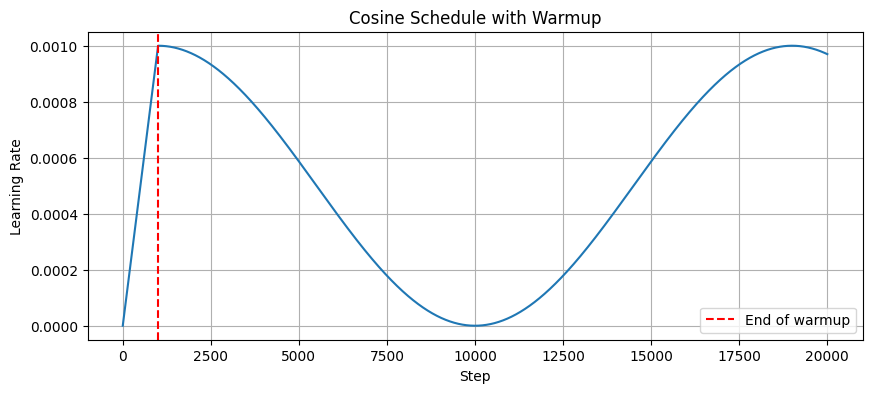

In [34]:
def cosine_schedule_with_warmup(step, base_lr, warmup_steps, total_steps, min_lr_ratio=0.0):
    """Cosine learning rate schedule with linear warmup."""
    if step < warmup_steps:
        # Linear warmup
        return base_lr * step / warmup_steps
    
    # Cosine decay
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    return base_lr * (min_lr_ratio + (1 - min_lr_ratio) * 0.5 * (1 + math.cos(math.pi * progress)))

# Visualize the schedule
steps = list(range(20000))
lrs = [cosine_schedule_with_warmup(s, base_lr=0.001, warmup_steps=1000, total_steps=10000) for s in steps]

plt.figure(figsize=(10, 4))
plt.plot(steps, lrs)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Cosine Schedule with Warmup')
plt.axvline(x=1000, color='r', linestyle='--', label='End of warmup')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Using PyTorch's built-in schedulers
model = nn.Linear(10, 5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Option 1: Lambda LR (most flexible, used in TRM)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_schedule_with_warmup(
        step, base_lr=1.0, warmup_steps=100, total_steps=1000
    )
)

# Option 2: CosineAnnealingWarmRestarts (built-in)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=1000, eta_min=0.0001
)

# In training loop:
# for step in range(total_steps):
#     train_step()
#     scheduler.step()  # Update LR after each step

## 13. IterableDataset

TRM uses `IterableDataset` for streaming data (more memory efficient than loading everything).

In [25]:
from torch.utils.data import IterableDataset, DataLoader
import numpy as np

class SimpleIterableDataset(IterableDataset):
    """Simplified version of TRM's puzzle dataset."""
    
    def __init__(self, num_samples: int, seq_len: int, vocab_size: int):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        
    def __iter__(self):
        for _ in range(self.num_samples):
            # Generate random sequence (in TRM, this would read from disk)
            inputs = torch.randint(0, self.vocab_size, (self.seq_len,))
            labels = torch.randint(0, self.vocab_size, (self.seq_len,))
            
            yield {
                'inputs': inputs,
                'labels': labels
            }

# Create dataset and dataloader
dataset = SimpleIterableDataset(num_samples=100, seq_len=32, vocab_size=50)
dataloader = DataLoader(dataset, batch_size=4)

# Get a batch
batch = next(iter(dataloader))
print(f"Batch inputs shape: {batch['inputs'].shape}")
print(f"Batch labels shape: {batch['labels'].shape}")

Batch inputs shape: torch.Size([4, 32])
Batch labels shape: torch.Size([4, 32])


In [26]:
# Memory-mapped arrays (used in TRM for large datasets)
# This reads data directly from disk without loading into memory

# Create a sample memory-mapped file
data = np.random.randint(0, 100, (1000, 32), dtype=np.int32)
np.save('/tmp/sample_data.npy', data)

# Load as memory-mapped (doesn't load into RAM)
mmap_data = np.load('/tmp/sample_data.npy', mmap_mode='r')
print(f"Memory-mapped array shape: {mmap_data.shape}")

# Access specific rows (only loads those rows into memory)
sample = mmap_data[10:14]  # Get rows 10-13
print(f"Sample shape: {sample.shape}")

Memory-mapped array shape: (1000, 32)
Sample shape: (4, 32)


## 14. torch.compile (Model Compilation)

TRM uses `torch.compile()` for faster execution.

In [27]:
# torch.compile optimizes the model using the TorchDynamo compiler
# This can significantly speed up training and inference

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
        )
        
    def forward(self, x):
        return self.layers(x)

model = SimpleModel()

# Compile the model (TRM does this unless DISABLE_COMPILE is set)
# Note: This requires PyTorch 2.0+
try:
    compiled_model = torch.compile(model)
    print("Model compiled successfully!")
    
    # First run is slower (compilation happens)
    x = torch.randn(32, 256)
    _ = compiled_model(x)
    print("First forward pass completed (compilation done)")
except Exception as e:
    print(f"Compilation not available: {e}")

Model compiled successfully!
First forward pass completed (compilation done)


## 15. EMA (Exponential Moving Average)

TRM optionally uses EMA for model weights during training.

In [28]:
class EMA:
    """Exponential Moving Average of model parameters."""
    
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.model = model
        self.decay = decay
        # Store shadow copies of parameters
        self.shadow = {name: p.data.clone() for name, p in model.named_parameters()}
        
    @torch.no_grad()
    def update(self):
        """Update shadow parameters with EMA."""
        for name, p in self.model.named_parameters():
            # shadow = decay * shadow + (1 - decay) * new_value
            self.shadow[name].lerp_(p.data, 1 - self.decay)
            
    def apply_shadow(self):
        """Replace model params with shadow params (for evaluation)."""
        self.backup = {name: p.data.clone() for name, p in self.model.named_parameters()}
        for name, p in self.model.named_parameters():
            p.data.copy_(self.shadow[name])
            
    def restore(self):
        """Restore original params (after evaluation)."""
        for name, p in self.model.named_parameters():
            p.data.copy_(self.backup[name])

# Example usage
model = nn.Linear(10, 5)
ema = EMA(model, decay=0.99)

# During training:
for step in range(100):
    # ... training step ...
    ema.update()  # Update EMA after each step

# For evaluation:
ema.apply_shadow()  # Use EMA weights
# ... evaluate ...
ema.restore()  # Restore training weights

print("EMA example complete!")

EMA example complete!


## 16. Distributed Training Basics

TRM supports multi-GPU training. Here's a quick overview of the concepts (run single-GPU here).

In [29]:
# Distributed training overview (concepts, not runnable in notebook)

# 1. Initialize process group (one process per GPU)
# torch.distributed.init_process_group(backend='nccl')

# 2. Get rank (process ID) and world size (total processes)
# rank = torch.distributed.get_rank()  # 0, 1, 2, ... for each GPU
# world_size = torch.distributed.get_world_size()  # Total number of GPUs

# 3. Key operations used in TRM:

# broadcast - Send tensor from one rank to all
# torch.distributed.broadcast(tensor, src=0)  # Rank 0 sends to all

# all_reduce - Reduce (sum) tensors across all ranks
# torch.distributed.all_reduce(grad_tensor)  # Sum gradients across GPUs

# all_gather - Gather tensors from all ranks
# torch.distributed.all_gather(output_list, input_tensor)

print("Distributed concepts (see TRM's pretrain.py for real implementation):")
print("- broadcast: sync parameters/data from rank 0")
print("- all_reduce: aggregate gradients across GPUs")
print("- all_gather: collect outputs from all GPUs")

Distributed concepts (see TRM's pretrain.py for real implementation):
- broadcast: sync parameters/data from rank 0
- all_reduce: aggregate gradients across GPUs
- all_gather: collect outputs from all GPUs


## 17. Complete Training Loop

Here's a simplified training loop that combines concepts from TRM.

In [30]:
# Simplified TRM-style training loop

@dataclass
class TrainState:
    model: nn.Module
    optimizer: torch.optim.Optimizer
    step: int = 0
    carry: Optional[ModelCarry] = None

def train_epoch(train_state: TrainState, dataloader, total_steps: int):
    model = train_state.model
    model.train()
    
    for batch in dataloader:
        # Move to device
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        
        # Initialize carry if needed
        if train_state.carry is None:
            train_state.carry = model.initial_carry(
                batch_size=inputs.shape[0],
                seq_len=inputs.shape[1]
            )
        
        # Forward pass
        output, train_state.carry = model(inputs, train_state.carry)
        
        # Compute loss
        loss = F.cross_entropy(
            output.view(-1, output.shape[-1]),
            labels.view(-1)
        )
        
        # Backward
        loss.backward()
        
        # Update
        train_state.optimizer.step()
        train_state.optimizer.zero_grad()
        
        # Update learning rate (manual, like TRM)
        lr = cosine_schedule_with_warmup(
            train_state.step,
            base_lr=0.001,
            warmup_steps=100,
            total_steps=total_steps
        )
        for param_group in train_state.optimizer.param_groups:
            param_group['lr'] = lr
        
        train_state.step += 1
        
        if train_state.step % 10 == 0:
            print(f"Step {train_state.step}: loss={loss.item():.4f}, lr={lr:.6f}")
            
        if train_state.step >= total_steps:
            break

print("Training loop defined (see next cell to run)")

Training loop defined (see next cell to run)


In [31]:
# Create a simple model and run training
class TinyModel(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, vocab_size)
        self.H_init = nn.Buffer(torch.zeros(1, 1, hidden_size))
        
    def initial_carry(self, batch_size, seq_len):
        return ModelCarry(
            z_H=self.H_init.expand(1, batch_size, self.hidden_size).contiguous(),
            z_L=torch.zeros(batch_size, seq_len, self.hidden_size)
        )
        
    def forward(self, x, carry):
        emb = self.embedding(x)
        output, h_new = self.rnn(emb, carry.z_H)
        logits = self.output(output)
        new_carry = ModelCarry(z_H=h_new.detach(), z_L=output.detach())
        return logits, new_carry

# Setup
vocab_size = 50
hidden_size = 64
model = TinyModel(vocab_size, hidden_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
train_state = TrainState(model=model, optimizer=optimizer)

# Dataset
dataset = SimpleIterableDataset(num_samples=200, seq_len=32, vocab_size=vocab_size)
dataloader = DataLoader(dataset, batch_size=8)

# Train
print("Starting training...")
train_epoch(train_state, dataloader, total_steps=50)
print("\nTraining complete!")

Starting training...
Step 10: loss=3.9052, lr=0.000090
Step 20: loss=3.9355, lr=0.000190

Training complete!


## Summary: Key TRM Patterns

1. **Model Architecture**: Hierarchical `nn.Module` with blocks, attention, and SwiGLU FFN
2. **State Management**: Dataclass carries (`ModelCarry`) for recursive hidden states
3. **Gradient Control**: `torch.no_grad()` for efficiency, `.detach()` for carry states
4. **Mixed Precision**: `bfloat16` for compute, `float32` for loss
5. **Custom Layers**: RMSNorm, RoPE, SwiGLU
6. **Loss Functions**: Cross-entropy for LM, BCE for Q-learning
7. **Optimizers**: Multiple optimizer groups, custom SignSGD for embeddings
8. **LR Scheduling**: Cosine annealing with warmup
9. **Data Loading**: `IterableDataset` with memory-mapped arrays
10. **Compilation**: `torch.compile()` for speed